In [1]:
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from tqdm.notebook import tqdm

from qsa_pwfa.simulation import Simulation as Simulation_old
from qsa_pwfa.new_methods.simulation import Simulation as Simulation_new

from qsa_pwfa.utils import get_density, get_field, get_Psi_new_grid

n_plasma = 1e17 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

In [2]:
"""
CASE 1

nb/n0 = 5
kp*sigma_r = 0.1
kp_sigma_z = 1
Lambda = 0.05)
"""

# Beam 
n_b = 0.001
R_b = 0.1
ksi0 = 5
R_xi = 1

# plasma
L_xi =  18
L_r = 10.0/4

# grid
N_xi = 512
d_xi = L_xi / N_xi

# dr = 0.03 * d_xi
# N_r = int(np.ceil(L_r/dr / 4)*4)
# L_r = N_r * dr

N_r = 2048
dr = L_r / N_r

n_b * (2*np.pi)**1.5 * (k_p_inv*R_b)**2 * (k_p_inv*R_xi) * 1e23 * e * 1e12

0.01197478465402465

In [3]:
sim_old = Simulation_old(L_xi=L_xi, N_xi=N_xi, L_r=L_r, N_r=N_r, dens_func=lambda r: 1 )
sim_old.init_beam(n_b, R_b, ksi0, R_xi)

sim_new = Simulation_new(L_xi=L_xi, N_xi=N_xi, L_r=L_r, N_r=N_r, dens_func=lambda r: 1 )
sim_new.init_beam(n_b, R_b, ksi0, R_xi)

<IPython.core.display.Javascript object>


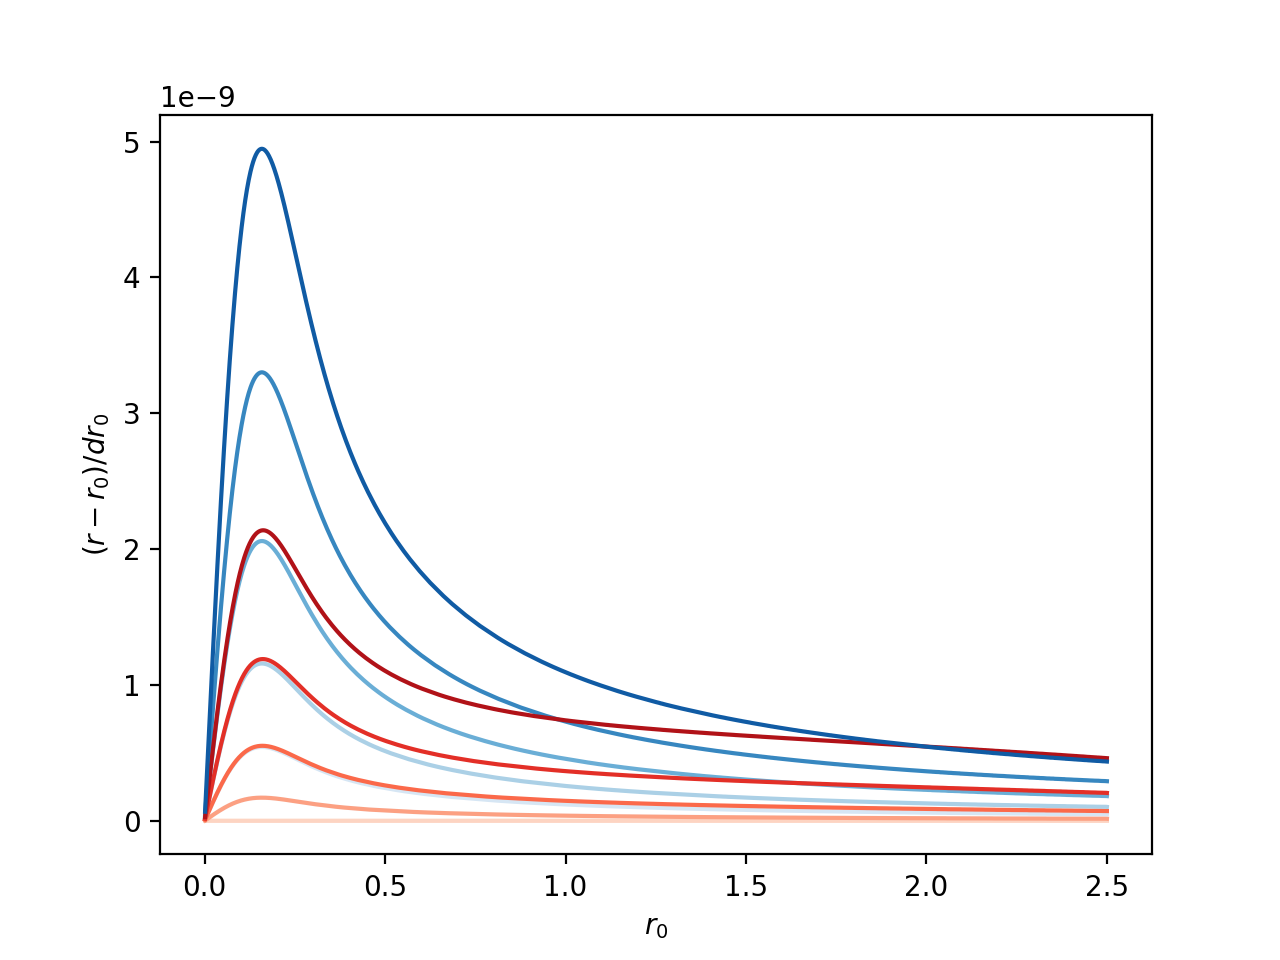

reached error 1 in 0 iterations
reached error 1 in 0 iterations
reached error 1 in 0 iterations
reached error 1 in 0 iterations
reached error 1 in 0 iterations
reached error 1 in 0 iterations


Text(0, 0.5, '$(r-r_0)/dr_0$')

In [4]:
plt.figure()

N_xi = 6

for i_xi in range(N_xi):
    sim_new.advance_xi(iter_max=0)
    sim_old.advance_xi()
    plt.plot(sim_new.r0, (sim_new.r-sim_new.r0) / sim_new.dr0, c=plt.cm.Reds(i_xi/N_xi))
    plt.plot(sim_old.r0, (sim_old.r-sim_old.r0) / sim_old.dr0 , c=plt.cm.Blues(i_xi/N_xi))
    
plt.xlabel('$r_0$')
plt.ylabel('$(r-r_0)/dr_0$')